In [ ]:
!pip install healpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 32.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
# simulation data from DCC fits files
# og_df = pd.read_csv('simple_model_images_files_data.csv')

In [ ]:
def get_vertices(df, index):
    '''
    Function to convert ra and dec values into vectors compatible with healpy
    Arguments: The dataframe and the index value of the row corresponding to the SCA that will be plotted.
    Returns: An array of vertices in the form of vectors for each corner of the SCA.
    '''
    ra1 = df['RA1'][index]
    ra2 = df['RA2'][index]
    ra3 = df['RA3'][index]
    ra4 = df['RA4'][index]
    dec1 = df['DEC1'][index]
    dec2 = df['DEC2'][index]
    dec3 = df['DEC3'][index]
    dec4 = df['DEC4'][index]
    def ra_dec_to_theta_phi(ra, dec):
        ra_rad = np.radians(ra)
        dec_rad = np.radians(dec)
        theta = np.pi / 2 - dec_rad
        phi = ra_rad
        return theta, phi
    theta1, phi1 = ra_dec_to_theta_phi(ra1, dec1)
    theta2, phi2 = ra_dec_to_theta_phi(ra2, dec2)
    theta3, phi3 = ra_dec_to_theta_phi(ra3, dec3)
    theta4, phi4 = ra_dec_to_theta_phi(ra4, dec4)
    vec1 = hp.ang2vec(theta1, phi1)
    vec2 = hp.ang2vec(theta2, phi2)
    vec3 = hp.ang2vec(theta3, phi3)
    vec4 = hp.ang2vec(theta4, phi4)
    vertices = np.array([vec1, vec2, vec3, vec4])
    return vertices

In [ ]:
def translate_squares(df, shift=0.01, upward_repetitions=1, left_translation=True, downward_repetitions=1):
    """
    Function to create the tiling of the footprint, following the snake pattern outlined in (Wang et al., 2023). It works left to right if visualized using healpy gnomview().
    Arguments:
        df: Must be a dataframe that contains only one pointing (only 18 rows). Contains columns RA{i} and DEC{i} for the 4 corner coordinates of every SCA.
        shift: change this value to alter the spacing between rows of pointings. (Increase it and the space between decreases and vice versa.)
        upward_repetitions: One less than the number of desired rows
        left translation: True if another column is desired.
        downward_repetitions: One less than the number of desired rows
    Output: Original dataframe with the rows corresponding to the new pointings appended to the end.

    """
    # Step 1: Identify the bounding box
    single_pointing = df.tail(18)
    min_dec = single_pointing[['DEC1', 'DEC2', 'DEC3', 'DEC4']].min().min()
    max_dec = single_pointing[['DEC1', 'DEC2', 'DEC3', 'DEC4']].max().max()


    # Step 2: Calculate the upward translation distance
    translation_distance_up = max_dec - min_dec - shift

    # Initialize the result dataframe with the original data
    result_df = df.copy()

    # Step 3: Apply the upward translations
    for i in range(upward_repetitions):
        # Translate each corner's Dec coordinates upward
        translated_df = single_pointing.copy()
        translated_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']] += (i + 1) * translation_distance_up

        # Append the translated squares to the result dataframe
        result_df = pd.concat([result_df, translated_df], ignore_index=True)

    if left_translation:
        # Step 4: Extract the last set of translated squares
        last_set = result_df.tail(18)

        # Step 5: Calculate the left translation distance
        min_ra = last_set[['RA1', 'RA2', 'RA3', 'RA4']].min().min()
        max_ra = last_set[['RA1', 'RA2', 'RA3', 'RA4']].max().max()
        translation_distance_left = max_ra - min_ra - shift

        # Step 6: Apply the left translation to the last set
        last_set_left_translated = last_set.copy()
        last_set_left_translated[['RA1', 'RA2', 'RA3', 'RA4']] += translation_distance_left

        # Append the left-translated squares to the result dataframe
        result_df = pd.concat([result_df, last_set_left_translated], ignore_index=True)

        # Step 7: Apply the downward translations to the left-translated set
        for i in range(downward_repetitions):
            downward_translated_df = last_set_left_translated.copy()
            downward_translated_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']] -= (i + 1) * translation_distance_up
            result_df = pd.concat([result_df, downward_translated_df], ignore_index=True)

    return result_df

In [ ]:
def rotate_point(x, y, angle_rad):
    """Rotate a point clockwise by a given angle around the origin (0, 0)."""
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)

    x_new = cos_angle * x + -sin_angle * y
    y_new = sin_angle * x + cos_angle * y

    return x_new, y_new

In [ ]:
def rotate_squares(df, foot_angle_deg):
    '''
    Function to rotate the footprint clockwise once as viewed in the gnomview projection.
    Commented out, there is code to also rotate individual pointings if desired. The angle of rotation and a list of lists of indices corresponding to the groups of SCAs in a pointing would need to be added as arguments in the function.
    The previous names for these arguments were point_angle_deg and subset_indices_list.
    Inputs:
        Dataframe that contains the rows for the footprint.
        foot_angle_deg is the rotation angle in degrees that you want to rotate the footprint by.
    Output: A dataframe of corner ra and dec coordinates for the rotated footprint. (If angle is 0 then it is the ra and dec coordinates for the original footprint).
    '''
    # Convert angles from degrees to radians
    angle_rad = np.radians(foot_angle_deg)
    #subset_angle_rad = np.radians(point_angle_deg)

    # Calculate the center of the entire set
    ra_center = df[[f'RA{i}' for i in range(1, 5)]].values.mean()
    dec_center = df[[f'DEC{i}' for i in range(1, 5)]].values.mean()

    # Initialize an empty DataFrame to store rotated squares
    rotated_data = {f'RA{i}': [] for i in range(1, 5)}
    rotated_data.update({f'DEC{i}': [] for i in range(1, 5)})

    # Apply the initial rotation to the entire set
    for index, row in (df.tail(648)).iterrows():
        for i in range(1, 5):
            ra, dec = row[f'RA{i}'], row[f'DEC{i}']

            # Translate points to origin (center of the entire set)
            ra_translated = ra - ra_center
            dec_translated = dec - dec_center

            # Rotate the points
            ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, angle_rad)

            # Translate points back to the original position
            rotated_data[f'RA{i}'].append(ra_rot + ra_center)
            rotated_data[f'DEC{i}'].append(dec_rot + dec_center)

    # Create a DataFrame for the initially rotated squares
    rotated_df = pd.DataFrame(rotated_data)

    # Apply the additional rotation to each subset
    #for subset_indices in subset_indices_list:
     #   subset_df = rotated_df.iloc[subset_indices]
      #  ra_center_subset = subset_df[[f'RA{i}' for i in range(1, 5)]].values.mean()
       # dec_center_subset = subset_df[[f'DEC{i}' for i in range(1, 5)]].values.mean()

        #for index in subset_indices:
         #   row = rotated_df.loc[index]
          #  for i in range(1, 5):
           #     ra, dec = row[f'RA{i}'], row[f'DEC{i}']

                # Translate points to origin (center of the subset)
              #  ra_translated = ra - ra_center_subset
               # dec_translated = dec - dec_center_subset

                # Rotate the points
                #ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, subset_angle_rad)

                # Translate points back to the original position
                #rotated_df.at[index, f'RA{i}'] = ra_rot + ra_center_subset
                #rotated_df.at[index, f'DEC{i}'] = dec_rot + dec_center_subset

    # Concatenate the original and rotated DataFrames
    #result_df = pd.concat([df, rotated_df], ignore_index=True)
    result_df = rotated_df

    return result_df

In [ ]:
def rotate_squares_custom(df, foot_angle_deg, ra_axis, dec_axis):
    '''
    Function to rotate the sky map clockwise around a user-specified axis.
    '''
    angle_rad = np.radians(foot_angle_deg)

    rotated_data = {f'RA{i}': [] for i in range(1, 5)}
    rotated_data.update({f'DEC{i}': [] for i in range(1, 5)})

    for _, row in df.iterrows():
        for i in range(1, 5):
            ra, dec = row[f'RA{i}'], row[f'DEC{i}']

            ra_translated = ra - ra_axis
            # ra_translated = (ra - ra_axis + 360) % 360
            # print(ra_translated)
            dec_translated = dec - dec_axis
            ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, angle_rad)

            rotated_data[f'RA{i}'].append(ra_rot + ra_axis)
            rotated_data[f'DEC{i}'].append(dec_rot + dec_axis)

    rotated_df = pd.DataFrame(rotated_data)
    return rotated_df


In [ ]:
def calculate_coverage(df, total_degrees=365):
    """
    Calculates the effectiveness of sky coverage after each degree rotation and overall.

    Returns:
        coverage_per_rotation: List of effectiveness (fraction of original area covered) at each degree.
        overall_coverage: Average effectiveness over the year.
    """
    #Fetch pixels for the original region
    original_pixels = set()
    for index in df.index:
        vertices = get_vertices(df, index)  # Get the vertices for each region at t=0
        original_pixels.update(hp.query_polygon(NSIDE, vertices, inclusive=False))

    total_original_pixels = len(original_pixels)

    #Rotate the region and calculate coverage
    coverage_per_rotation = []
    for degree in range(total_degrees + 1):  # Include t=0
        # Rotate the region
        rotated_df = rotate_squares(df, degree)

        #Fetch pixels for rotated region
        rotated_pixels = set()
        for index in rotated_df.index:
            vertices = get_vertices(rotated_df, index)
            rotated_pixels.update(hp.query_polygon(NSIDE, vertices, inclusive=False))

        #Overlap calculation
        overlap_pixels = original_pixels & rotated_pixels  # Intersection of original and rotated
        coverage_fraction = len(overlap_pixels) / total_original_pixels


        coverage_per_rotation.append(coverage_fraction)

    #Overall coverage (mean) calculation
    overall_coverage = np.mean(coverage_per_rotation)

    return coverage_per_rotation, overall_coverage

In [ ]:
def visualize_effectiveness(effectiveness_per_rotation, overall_effectiveness):
    """
    For visualizing the efficiency (overlap) of sky coverage at various values of degree rotation.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(effectiveness_per_rotation)), effectiveness_per_rotation, label="Effectiveness per Rotation")
    plt.xlabel("Rotation (Degrees)")
    plt.ylabel("Effectiveness")
    plt.title("Effectiveness of Sky Coverage with Each Rotation")
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Overall Effectiveness After 1 Year: {overall_effectiveness * 100:.2f}%")

In [ ]:
def create_trans_sq(og_df, data):
    """
    Utilised the code from earlier notebook to create the tiling strategy 8*5 = 40 exposures
    """
    up1, up2, up3, up4, up5 = data['up1'], data['up2'], data['up3'], data['up4'], data['up5']
    dw1, dw2, dw3, dw4, dw5 = data['dw1'], data['dw2'], data['dw3'], data['dw4'] ,data['up5']
    shift1, shift2, shift3, shift4, shift5 = data['shift1'], data['shift2'], data['shift3'], data['shift4'], data['shift5']
    left_tr1, left_tr2, left_tr3, left_tr4, left_tr5 = data['left_tr1'], data['left_tr2'], data['left_tr3'], data['left_tr4'], data['left_tr5']
    pointing_num = data['pointing_num']

    df = og_df[(og_df['POINTING'] == pointing_num)]

    #Finishes the first column and makes the second column
    trans = translate_squares(df, shift=shift1, upward_repetitions=up1, left_translation=left_tr1, downward_repetitions=dw1)
    #Starts the third column
    trans2 = translate_squares(trans, shift=shift2, upward_repetitions=up2, left_translation=left_tr2, downward_repetitions=dw2)
    #Finishes the third column and makes the fourth
    trans3 = translate_squares(trans2, shift=shift3, upward_repetitions=up3, left_translation=left_tr3, downward_repetitions=dw3)
    #Starts the fifth column
    trans4 = translate_squares(trans3, shift=shift4, upward_repetitions=up4, left_translation=left_tr4, downward_repetitions=dw4)
    #Finishes the fifth column
    new_df = translate_squares(trans4, shift=shift5, upward_repetitions=up5, left_translation=left_tr5, downward_repetitions=dw5)


    return new_df


In [ ]:
def create_trans_sq_customTest(og_df, data):
    """
    Utilised for testing purpose on a smaller region.
    """
    up1, up2, up3, up4, up5 = data['up1'], data['up2'], data['up3'], data['up4'], data['up5']
    dw1, dw2, dw3, dw4, dw5 = data['dw1'], data['dw2'], data['dw3'], data['dw4'] ,data['up5']
    shift1, shift2, shift3, shift4, shift5 = data['shift1'], data['shift2'], data['shift3'], data['shift4'], data['shift5']
    left_tr1, left_tr2, left_tr3, left_tr4, left_tr5 = data['left_tr1'], data['left_tr2'], data['left_tr3'], data['left_tr4'], data['left_tr5']
    pointing_num = data['pointing_num']

    df = og_df[(og_df['POINTING'] == pointing_num)]

    #Finishes the first column and makes the second column
    trans = translate_squares(df, shift=shift1, upward_repetitions=up1, left_translation=left_tr1, downward_repetitions=dw1)
    #Starts the third column
    # trans2 = translate_squares(trans, shift=shift2, upward_repetitions=up2, left_translation=left_tr2, downward_repetitions=dw2)
    # #Finishes the third column and makes the fourth
    # trans3 = translate_squares(trans2, shift=shift3, upward_repetitions=up3, left_translation=left_tr3, downward_repetitions=dw3)
    # #Starts the fifth column
    # trans4 = translate_squares(trans3, shift=shift4, upward_repetitions=up4, left_translation=left_tr4, downward_repetitions=dw4)
    # #Finishes the fifth column
    # new_df = translate_squares(trans4, shift=shift5, upward_repetitions=up5, left_translation=left_tr5, downward_repetitions=dw5)


    return trans


In [ ]:
def remove_edges(og_df, new_df, filter_val='K213', filter_pointing_num='K'):
    """
    Removing the corners to get the required 36 exposures.
    """
    filter_dict = {
        'R': [0, 7, 39, 32],
        'Z': [55, 62, 94, 87],
        'J': [165, 172, 204, 197],
        'H': [220, 227, 259, 252],
        'F': [275, 282, 314, 307],
        'K': [330, 337, 369, 362]
    }

    filter_vals = filter_dict[filter_pointing_num]

    filter_df = og_df[(og_df['FILTER'] == filter_val)]
    sorted_df = filter_df.sort_values(by='POINTING')

    ra1_array = new_df['RA1'].values
    ra2_array = new_df['RA2'].values
    ra3_array = new_df['RA3'].values
    ra4_array = new_df['RA4'].values
    dec1_array = new_df['DEC1'].values
    dec2_array = new_df['DEC2'].values
    dec3_array = new_df['DEC3'].values
    dec4_array = new_df['DEC1'].values

    SCA_array = new_df['SCA'].values
    filter_array = new_df['FILTER'].values
    exptime_array = new_df['EXPTIME'].values

    pointing_array = sorted_df['POINTING'].values
    mjd_array = sorted_df['MJD'].values
    dateobs_array = sorted_df['DATE-OBS'].values

    shape = SCA_array.shape[0]
    data = {
        'POINTING': pointing_array[:shape], #720
        'SCA': SCA_array,
        'FILTER': filter_array,
        'MJD': mjd_array[:shape],
        'EXPTIME': exptime_array,
        'DATE-OBS': dateobs_array[:shape],
        'RA1': ra1_array,
        'DEC1':dec1_array,
        'RA2': ra2_array,
        'DEC2': dec2_array,
        'RA3': ra3_array,
        'DEC3': dec3_array,
        'RA4': ra4_array,
        'DEC4': dec4_array
    }

    nuevo_df = pd.DataFrame(data)
    indices_to_drop = nuevo_df[nuevo_df['POINTING'] == filter_vals[0]].index
    nuevo_df.drop(indices_to_drop, inplace=True)


    indices_to_drop = nuevo_df[nuevo_df['POINTING'] == filter_vals[1]].index
    nuevo_df.drop(indices_to_drop, inplace=True)

    indices_to_drop = nuevo_df[nuevo_df['POINTING'] == filter_vals[2]].index
    nuevo_df.drop(indices_to_drop, inplace=True)

    indices_to_drop = nuevo_df[nuevo_df['POINTING'] == filter_vals[3]].index
    nuevo_df.drop(indices_to_drop, inplace=True)

    nuevo_df = nuevo_df.reset_index(drop=True)

    return nuevo_df

In [ ]:
def gen_tiling(og_df, data):
    '''
    Utilised the code from earlier notebook to create the tiling strategy 8*5 with corners removed = 36 exposures
    '''
    new_df = create_trans_sq(og_df, data)
    # new_df = create_trans_sq_customTest(og_df, data)
    final_df = remove_edges(og_df, new_df)

    return final_df

In [ ]:
def gen_tiling_customTest(og_df, data):
    '''
    Utilised the code from earlier notebook to create the custom tiling strategy
    '''
    # new_df = create_trans_sq(og_df, data)
    new_df = create_trans_sq_customTest(og_df, data)
    final_df = remove_edges(og_df, new_df)

    return final_df

In [ ]:
def visualize(new_df, mean_ra, mean_dec):
    '''
    Visualzing the region via healpy
    '''
    obs_rows = new_df.index # new_df
    #iterates through the list of indices for all of the rows that correspond to the SCAs in the new footprint and gets the list of pixels that the SCAs touch.
    ipix_box_list = []
    for index in obs_rows:
        vertices = get_vertices(new_df, index)
        ipix_box_single = hp.query_polygon(nside=NSIDE, vertices=vertices, inclusive=False)
        ipix_box_list.append(ipix_box_single)
    ipix_box = np.concatenate(ipix_box_list)
    # rot = [9.7, -44] #The point we want our image to be centered on. Not the exact center of the footprint because this is just for visualization.
    # mean_ra = new_df[['RA1', 'RA2', 'RA3', 'RA4']].mean().mean()
    # mean_dec = new_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']].mean().mean()
    rot = [mean_ra, mean_dec]
    m = np.zeros(hp.nside2npix(NSIDE)) #these 3 rows create the map that gets fed into healpy
    counts = np.bincount(ipix_box, minlength=len(m))
    m[:len(counts)] = counts
    hp.gnomview(m, rot=rot,title="Sky Location of Roman Pictures-Z087", reso = 1.6, xsize = 400) #plots the map centered on "rot". reso is the number of arcminutes per pixel and xsize is the number of pixels.
    plt.show()


In [ ]:
def create_heat_map(df, ra_axis, dec_axis, total_degrees=365, step=5):
    """
    Creates a heat map showing pixel retention over a time period (rotations every step degrees).
    """
    total_steps = total_degrees // step + 1
    heat_map = np.zeros(hp.nside2npix(NSIDE))

    for degree in range(0, total_degrees + 1, step):
        # rotated_df = rotate_squares(df, degree)
        rotated_df = rotate_squares_custom(df, degree, ra_axis, dec_axis)

        for index in rotated_df.index:
            vertices = get_vertices(rotated_df, index)
            pixels = hp.query_polygon(NSIDE, vertices, inclusive=False)
            heat_map[pixels] += 1

    heat_map /= heat_map.max()  # Normalize to 0–1 range

    # Display the heat map using gnomview
    mean_ra = df[['RA1', 'RA2', 'RA3', 'RA4']].mean().mean()
    mean_dec = df[['DEC1', 'DEC2', 'DEC3', 'DEC4']].mean().mean()
    rot = [mean_ra, mean_dec]
    hp.gnomview(heat_map, rot=rot, title="Heat Map of Sky Coverage Over 1 Year", reso=1.6, xsize=400, cmap='viridis')
    plt.show()

    return heat_map


In [ ]:
def calculate_pixel_efficiency(df, ra_axis, dec_axis, total_degrees=365, step=5):
    """
    Calculates pixel efficiency and records the degrees where each pixel appears.
    """
    total_steps = total_degrees // step + 1
    pixel_data = {}

    for degree in range(0, total_degrees + 1, step):
        rotated_df = rotate_squares_custom(df, degree, ra_axis, dec_axis)

        for index in rotated_df.index:
            vertices = get_vertices(rotated_df, index)
            pixels = hp.query_polygon(NSIDE, vertices, inclusive=False)

            for pixel in pixels:
                if pixel not in pixel_data:
                    pixel_data[pixel] = {"appearances": 0, "degrees": []}
                pixel_data[pixel]["appearances"] += 1
                pixel_data[pixel]["degrees"].append(degree)

    # final efficiency calc
    for pixel, data in pixel_data.items():
        data["efficiency"] = len(set(data["degrees"])) / total_steps

    return pixel_data

In [ ]:
def hist_plot(pixel_details):

    efficiency_vals = [pix["efficiency"] for _, pix in pixel_details.items()]

    plt.hist(efficiency_vals, bins=10, edgecolor='black')
    plt.title('Efficiency Distribution')
    plt.xlabel('Efficiency')
    plt.ylabel('Frequency')

    plt.show()

In [ ]:
#Initializing all the variables.

data = {
    'up1':7,
    'dw1':7,
    'up2':0,
    'dw2':0,
    'up3':7,
    'dw3':7,
    'up4':0,
    'dw4':0,
    'up5':7,
    'dw5':0,
    'left_tr1':True,
    'left_tr2':True,
    'left_tr3':True,
    'left_tr4':True,
    'left_tr5': False,
    'shift1': 0.01,
    'shift2': 0.01,
    'shift3': 0.01,
    'shift4': 0.01,
    'shift5': 0.01,
    'pointing_num':330
}
NSIDE = 4096
NPIX  = hp.nside2npix(NSIDE)

og_df = pd.read_csv('simple_model_images_files_data.csv')

In [ ]:
new_df = gen_tiling(og_df, data)

In [ ]:
ra_cen = new_df[[f'RA{i}' for i in range(1, 5)]].mean().mean()
dec_cen = new_df[[f'DEC{i}' for i in range(1, 5)]].mean().mean()
print(f"RA: {ra_cen}; DEC: {dec_cen}")

RA: 9.889758150728554; DEC: -43.90936239357259


astroPy -
rotation axis;
degree of rotation every 5 degrees


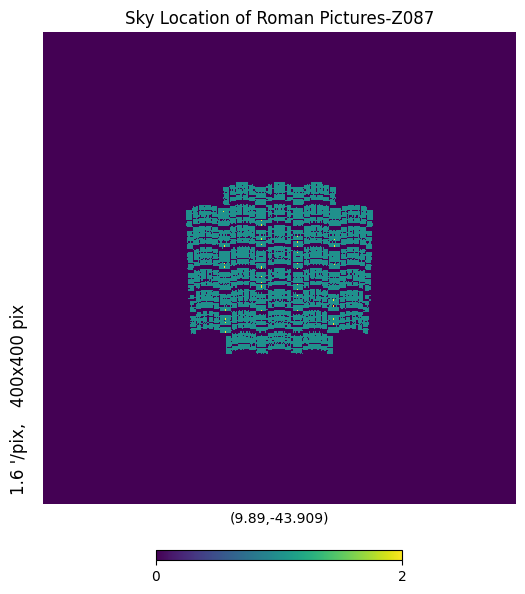

In [ ]:
visualize(new_df, ra_cen, dec_cen)

In [ ]:
ra_custom = new_df[[f'RA{i}' for i in range(1, 5)]].max().max()
dec_custom = new_df[[f'DEC{i}' for i in range(1, 5)]].mean().mean()
print(f"RA: {ra_custom}; DEC: {dec_custom}")

RA: 12.750262742838448; DEC: -43.90936239357259


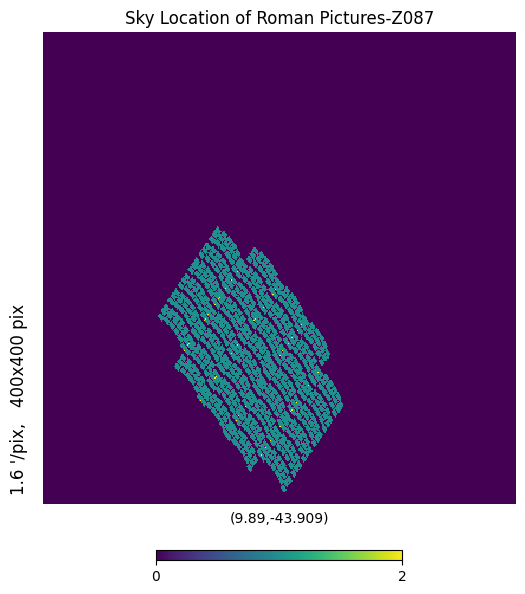

In [ ]:
#Rotating it by arbitrary value (theta) for visualization.

# result_df = rotate_squares(new_df, 200)
result_df = rotate_squares_custom(new_df, 45, ra_custom, dec_custom)
visualize(result_df, ra_cen, dec_cen)

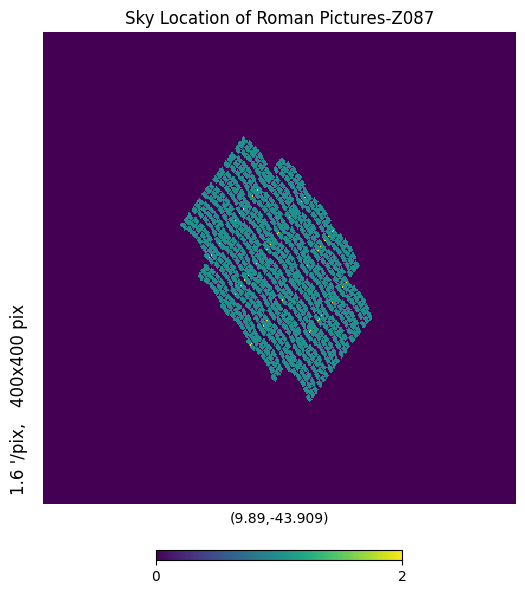

In [ ]:
#Rotating it by arbitrary value (theta) for visualization.

# result_df = rotate_squares(new_df, 200)
result_df = rotate_squares_custom(new_df, 45, ra_custom, dec_custom)
visualize(result_df, ra_cen, dec_cen)

Demo to check heat map for 1 step (0 & 5 degrees of rotation overlapped)

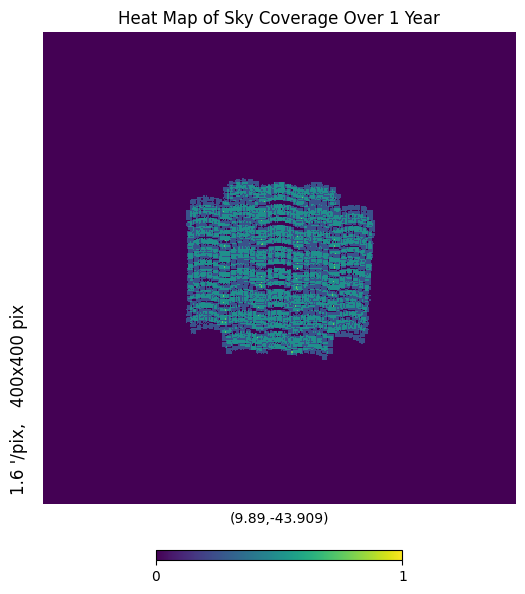

In [ ]:
heat_map = create_heat_map(new_df, ra_custom, dec_custom, total_degrees=5, step=5)

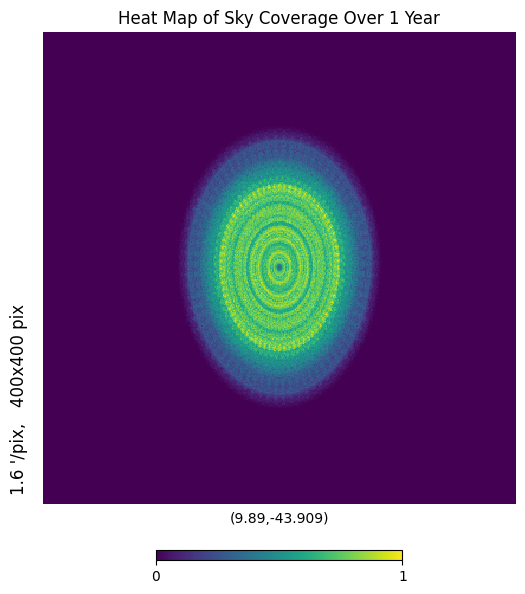

In [ ]:
heat_map = create_heat_map(new_df, ra_custom, dec_custom, total_degrees=365, step=5)

In [ ]:
pixel_details = calculate_pixel_efficiency(new_df, ra_custom, dec_custom, total_degrees=365, step=5)

max_val = 0
pix = -1
for pixel, details in list(pixel_details.items())[:]:
    if details['efficiency'] > max_val:
        max_val = details['efficiency']
        pix = pixel
    # print(f"Pixel {pixel}: Efficiency = {details['efficiency']:.2f}, Degrees = {details['degrees']}")

print(f"Max Efficiency for pixel: {pix} is {max_val:.2f}")

Max Efficiency for pixel: 168156513 is 0.91


In [ ]:
pixel_details[168156513]

{'appearances': 69,
 'degrees': [0,
  5,
  15,
  20,
  25,
  30,
  35,
  40,
  50,
  55,
  60,
  65,
  75,
  80,
  85,
  90,
  95,
  100,
  105,
  110,
  115,
  120,
  120,
  125,
  130,
  135,
  140,
  145,
  155,
  160,
  165,
  170,
  175,
  180,
  185,
  190,
  195,
  200,
  205,
  210,
  215,
  220,
  225,
  235,
  240,
  245,
  250,
  255,
  260,
  265,
  270,
  275,
  280,
  285,
  290,
  295,
  300,
  300,
  305,
  315,
  320,
  325,
  330,
  340,
  345,
  350,
  355,
  360,
  365],
 'efficiency': 0.9054054054054054}

In [ ]:
len(pixel_details)

111661

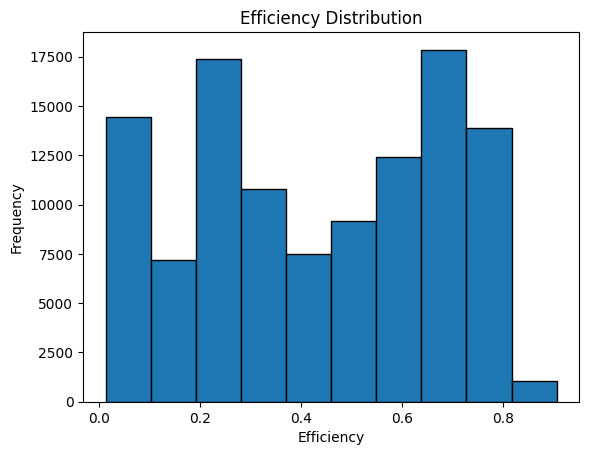

In [ ]:
hist_plot(pixel_details)

In [ ]:
#Calculating the effectiveness.

# effectiveness_per_rotation, overall_effectiveness = calculate_coverage(new_df, total_degrees=365)

In [ ]:
#For visualizing the efficiency (overlap) at various values of theta

# visualize_effectiveness(effectiveness_per_rotation, overall_effectiveness)

For single tile (1x1).

In [ ]:
test_data = {
    'up1':0,
    'dw1':0,
    'up2':0,
    'dw2':0,
    'up3':0,
    'dw3':0,
    'up4':0,
    'dw4':0,
    'up5':0,
    'dw5':0,
    'left_tr1':True,
    'left_tr2':True,
    'left_tr3':True,
    'left_tr4':True,
    'left_tr5': False,
    'shift1': 0.01,
    'shift2': 0.01,
    'shift3': 0.01,
    'shift4': 0.01,
    'shift5': 0.01,
    'pointing_num':330
}

In [ ]:
test_df = gen_tiling_customTest(og_df, test_data)

In [ ]:
ra_cen = test_df[[f'RA{i}' for i in range(1, 5)]].mean().mean()
dec_cen = test_df[[f'DEC{i}' for i in range(1, 5)]].mean().mean()
print(f"RA: {ra_cen}; DEC: {dec_cen}")

RA: 8.74754906855745; DEC: -45.587778147876755


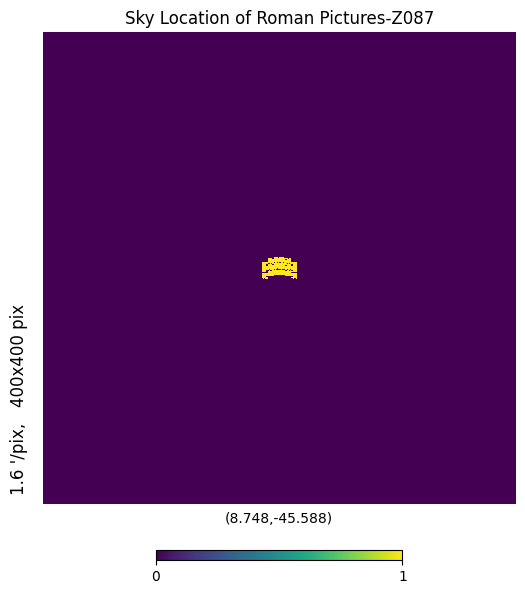

In [ ]:
# test_df = gen_tiling_customTest(og_df, test_data)
visualize(test_df, ra_cen, dec_cen)

In [ ]:
ra_custom = test_df[[f'RA{i}' for i in range(1, 5)]].mean().mean()
dec_custom = test_df[[f'DEC{i}' for i in range(1, 5)]].mean().mean()
print(f"RA: {ra_custom}; DEC: {dec_custom}")

RA: 8.74754906855745; DEC: -45.587778147876755


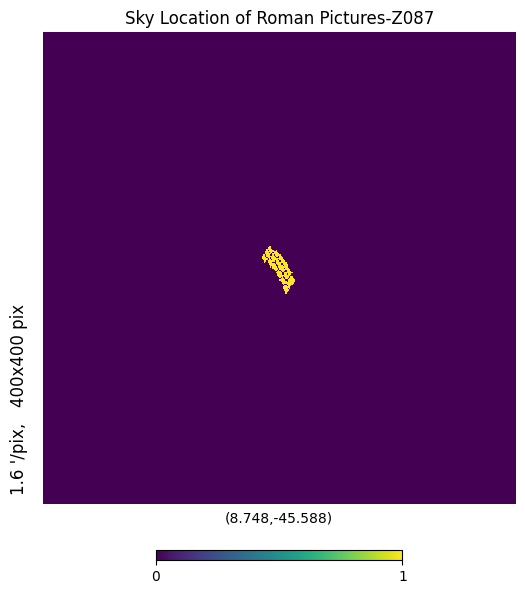

In [ ]:
#Rotating it by arbitrary value (theta) for visualization.

# resultTest_df = rotate_squares(test_df, 45)
resultTest_df = rotate_squares_custom(test_df, 45, ra_custom, dec_custom)
visualize(resultTest_df, ra_cen, dec_cen)

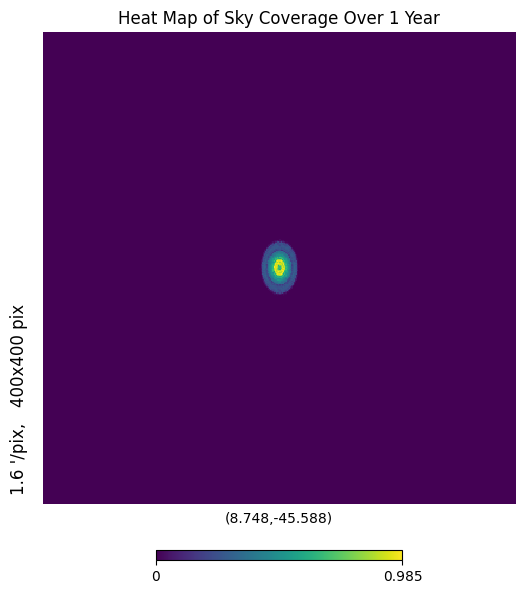

In [ ]:
heat_map = create_heat_map(test_df, ra_custom, dec_custom, total_degrees=365, step=5)

In [ ]:
# Usage
pixel_details = calculate_pixel_efficiency(test_df, ra_custom, dec_custom, total_degrees=365, step=5)

max_val = 0
pix = -1
for pixel, details in list(pixel_details.items()):
    if details['efficiency'] > max_val:
        max_val = details['efficiency']
        pix = pixel
    # print(f"Pixel {pixel}: Efficiency = {details['efficiency']:.2f}, Degrees = {details['degrees']}")

print(f"Max Efficiency for pixel: {pix} is: {max_val}")

Max Efficiency for pixel: 172757720 is: 0.918918918918919


In [ ]:
len(pixel_details)

4156

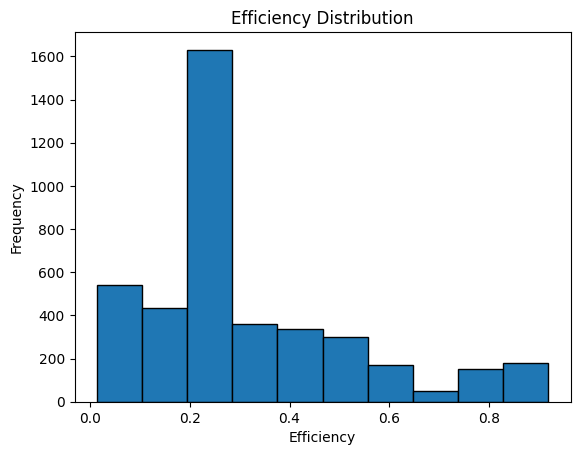

In [ ]:
hist_plot(pixel_details)

In [ ]:
# pixel_details[172757720]

In [ ]:
#Calculating the effectiveness.

# effectiveness_per_rotation_test, overall_effectiveness_test = calculate_coverage(test_df, total_degrees=365)

In [ ]:
#For visualizing the efficiency (overlap) at various values of theta

# visualize_effectiveness(effectiveness_per_rotation_test, overall_effectiveness_test)

For two tiles (2x1)

In [ ]:
test_data2 = {
    'up1':0,
    'dw1':1,
    'up2':0,
    'dw2':0,
    'up3':0,
    'dw3':0,
    'up4':0,
    'dw4':0,
    'up5':0,
    'dw5':0,
    'left_tr1':True,
    'left_tr2':True,
    'left_tr3':True,
    'left_tr4':True,
    'left_tr5': False,
    'shift1': 0.01,
    'shift2': 0.01,
    'shift3': 0.01,
    'shift4': 0.01,
    'shift5': 0.01,
    'pointing_num':330
}

In [ ]:
test_df2 = gen_tiling_customTest(og_df, test_data2)

In [ ]:
ra_cen = test_df2[[f'RA{i}' for i in range(1, 5)]].mean().mean()
dec_cen = test_df2[[f'DEC{i}' for i in range(1, 5)]].mean().mean()
print(f"RA: {ra_cen}; DEC: {dec_cen}")

RA: 8.747549068557449; DEC: -45.827551827063076


In [ ]:
test_df2.head()

,POINTING,SCA,FILTER,MJD,EXPTIME,DATE-OBS,RA1,DEC1,RA2,DEC2,RA3,DEC3,RA4,DEC4
0,331,16.0,K213,62002.34974,901.175,2028-08-19 08:23:37.536000,8.171426,-45.843243,8.174977,-45.720047,8.351735,-45.719567,8.348575,-45.843243
1,331,12.0,K213,62002.34974,901.175,2028-08-19 08:23:37.536000,8.738831,-45.353696,8.738117,-45.470578,8.562902,-45.471017,8.563979,-45.353696
2,331,5.0,K213,62002.34974,901.175,2028-08-19 08:23:37.536000,8.951542,-45.629321,8.949075,-45.509175,9.125200,-45.510016,9.128045,-45.629321
3,331,4.0,K213,62002.34974,901.175,2028-08-19 08:23:37.536000,8.951278,-45.777524,8.949109,-45.654832,9.126984,-45.655207,9.129545,-45.777524
4,331,2.0,K213,62002.34974,901.175,2028-08-19 08:23:37.536000,8.756147,-45.602850,8.755740,-45.482982,8.932526,-45.483543,8.933311,-45.602850


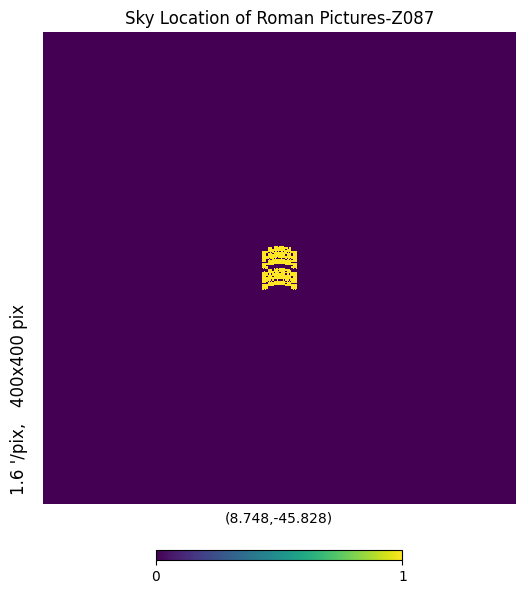

In [ ]:
# test_df2 = gen_tiling_customTest(og_df, test_data2)
visualize(test_df2, ra_cen, dec_cen)

In [ ]:
ra_custom = test_df2[[f'RA{i}' for i in range(1, 5)]].mean().mean()
dec_custom = test_df2[[f'DEC{i}' for i in range(1, 5)]].mean().mean()
print(f"RA: {ra_custom}; DEC: {dec_custom}")

RA: 8.747549068557449; DEC: -45.827551827063076


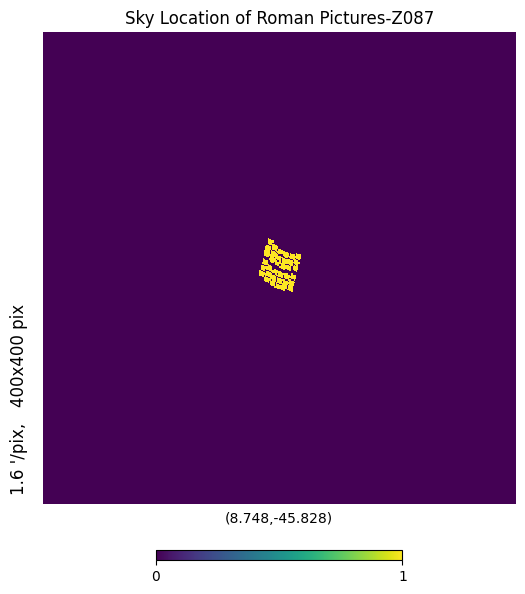

In [ ]:
#Rotating it by arbitrary value (theta) for visualization.

# resultTest_df2 = rotate_squares(test_df2, 200)
resultTest_df = rotate_squares_custom(test_df2, 200, ra_custom, dec_custom)
visualize(resultTest_df, ra_cen, dec_cen)

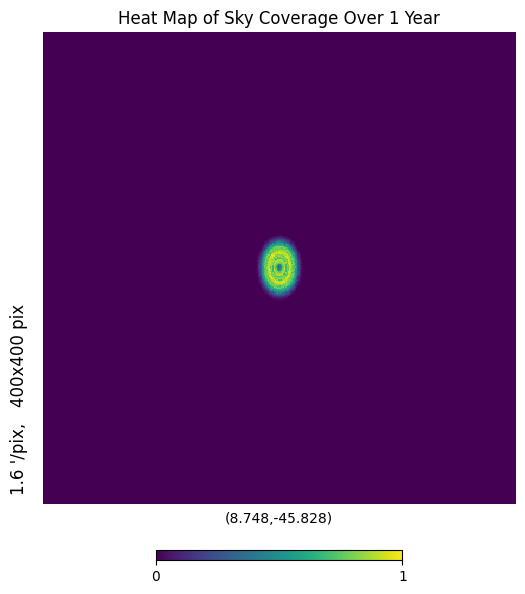

In [ ]:
heat_map = create_heat_map(test_df2, ra_custom, dec_custom, total_degrees=365, step=5)

In [ ]:
# Usage
pixel_details = calculate_pixel_efficiency(test_df2, ra_custom, dec_custom, total_degrees=365, step=5)

max_val = 0
pix = -1
for pixel, details in list(pixel_details.items())[:]:
    if details['efficiency'] > max_val:
        max_val = details['efficiency']
        pix = pixel
    # print(f"Pixel {pixel}: Efficiency = {details['efficiency']:.2f}, Degrees = {details['degrees']}")

print(f"Max Efficiency for pixel: {pix} is: {max_val}")

Max Efficiency for pixel: 172666952 is: 0.8648648648648649


In [ ]:
pixel_details[172666952]

{'appearances': 64,
 'degrees': [0,
  5,
  10,
  15,
  35,
  40,
  45,
  50,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100,
  105,
  110,
  115,
  120,
  125,
  130,
  135,
  140,
  145,
  150,
  155,
  160,
  165,
  170,
  175,
  185,
  190,
  195,
  200,
  220,
  225,
  230,
  235,
  245,
  250,
  255,
  260,
  265,
  270,
  275,
  280,
  285,
  290,
  295,
  300,
  305,
  310,
  315,
  320,
  325,
  330,
  335,
  340,
  345,
  350,
  360,
  365],
 'efficiency': 0.8648648648648649}

In [ ]:
len((set(pixel_details[172666952]['degrees'])))

64

In [ ]:
NSIDE = 4096
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 4096 is 0.014 deg


In [ ]:
#make cdf for 1x2;
#for y-axis freq * (area per healpix); NSIDE size ; (0.014)^2
#should match y-axis (page 15)
#repeat for (2,3) - verify the reuslts.
#replicate using astroPy

In [ ]:
pixel_freqs = []
for _, pix in pixel_details.items():
    pixel_freqs.append(len(set(pix['degrees'])))

area_per_pixel = (0.014)**2

sorted_freqs = np.sort(pixel_freqs)

pixel_areas = sorted_freqs * area_per_pixel

cumulative_areas = np.cumsum(pixel_areas)


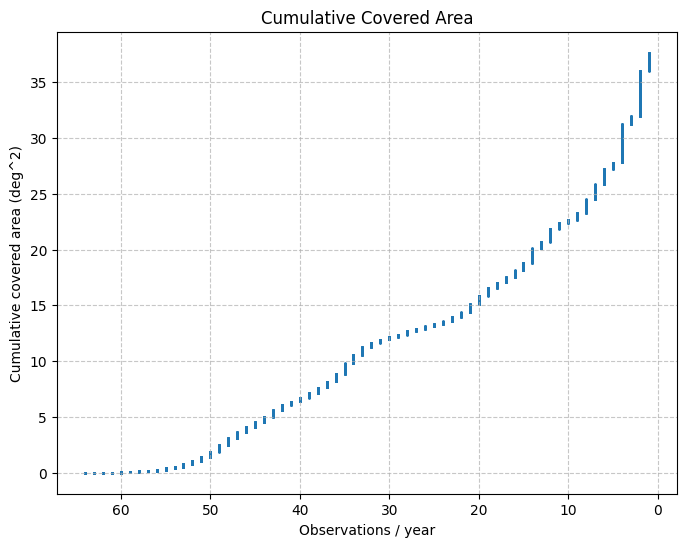

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(sorted_freqs[::-1], cumulative_areas, s=1)  # s controls dot size
plt.title("Cumulative Covered Area")
plt.xlabel("Observations / year")
plt.ylabel("Cumulative covered area (deg^2)")
plt.gca().invert_xaxis()  # Reverse X-axis to match earlier plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

37.6368999999997

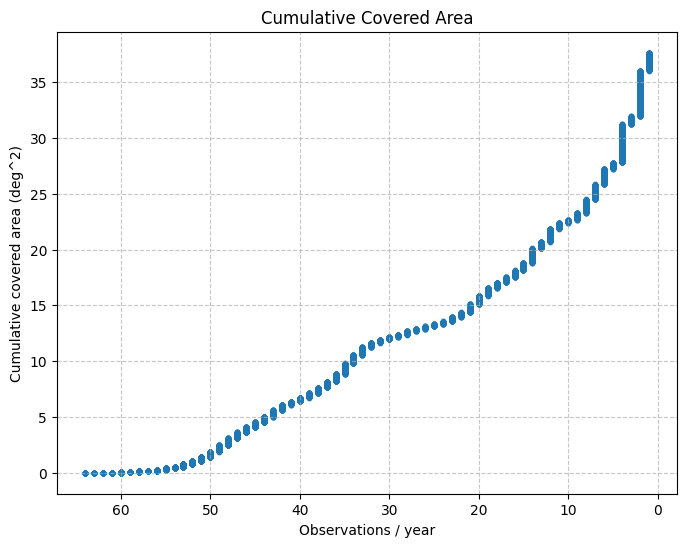

In [ ]:
# Define bins to align with X-axis ticks
bins = [0, 10, 20, 30, 40, 50, 60]

# Bin frequencies (use np.histogram to count pixels in each bin)
binned_frequencies = np.digitize(sorted_freqs[::-1], bins)

# Optional: Center bins for plotting (X-axis tick alignment)
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

# Create scatter plot for cumulative areas
plt.figure(figsize=(8, 6))
plt.scatter(sorted_freqs[::-1], cumulative_areas, s=10)  # Dot size = 10
plt.title("Cumulative Covered Area")
plt.xlabel("Observations / year")
plt.ylabel("Cumulative covered area (deg^2)")

# Adjust X-axis to show bins
plt.xticks(ticks=bins[::-1], labels=bins[::-1])  # Reverse X-axis ticks
plt.gca().invert_xaxis()  # Invert X-axis to match earlier plot

# Add gridlines and show
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
len(pixel_details)

5967

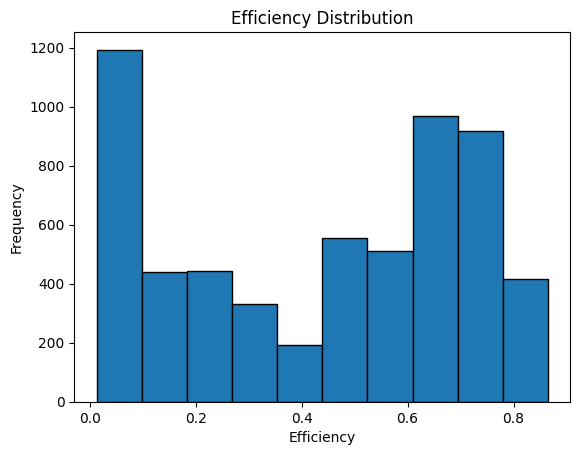

In [ ]:
hist_plot(pixel_details)

In [ ]:
#Calculating the effectiveness.

# effectiveness_per_rotation_test2, overall_effectiveness_test2 = calculate_coverage(test_df2, total_degrees=365)

In [ ]:
#For visualizing the efficiency (overlap) at various values of theta

# visualize_effectiveness(effectiveness_per_rotation_test2, overall_effectiveness_test2)